In [1]:
import PyPDF2
from PIL import Image
import pytesseract as pts
from googletrans import Translator
import re
import pandas as pd
import time
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# import numpy
# import cv2

## $\text{Convert Each Page to an Image}$
---

In [2]:
def pdf_to_images(pdf_file, image_prefix):
    pdf = PyPDF2.PdfReader(pdf_file)

    for page_number in range(len(pdf.pages)):
        page = pdf.pages[page_number]
        image = page_to_image(page)
        image.save(f"{image_prefix}_{page_number + 1}.png")

def page_to_image(page):
    xObject = page['/Resources']['/XObject'].get_object()
    for obj in xObject:
        if xObject[obj]['/Subtype'] == '/Image':
            img = xObject[obj]
            return Image.frombytes('RGB', [img['/Width'], img['/Height']], img.get_data())

In [3]:
# pdf_file = 'Tamil Nadu.pdf'
# image_prefix = 'page'
# pdf_to_images(pdf_file, image_prefix)

In [4]:
im = Image.open('page_3.png')

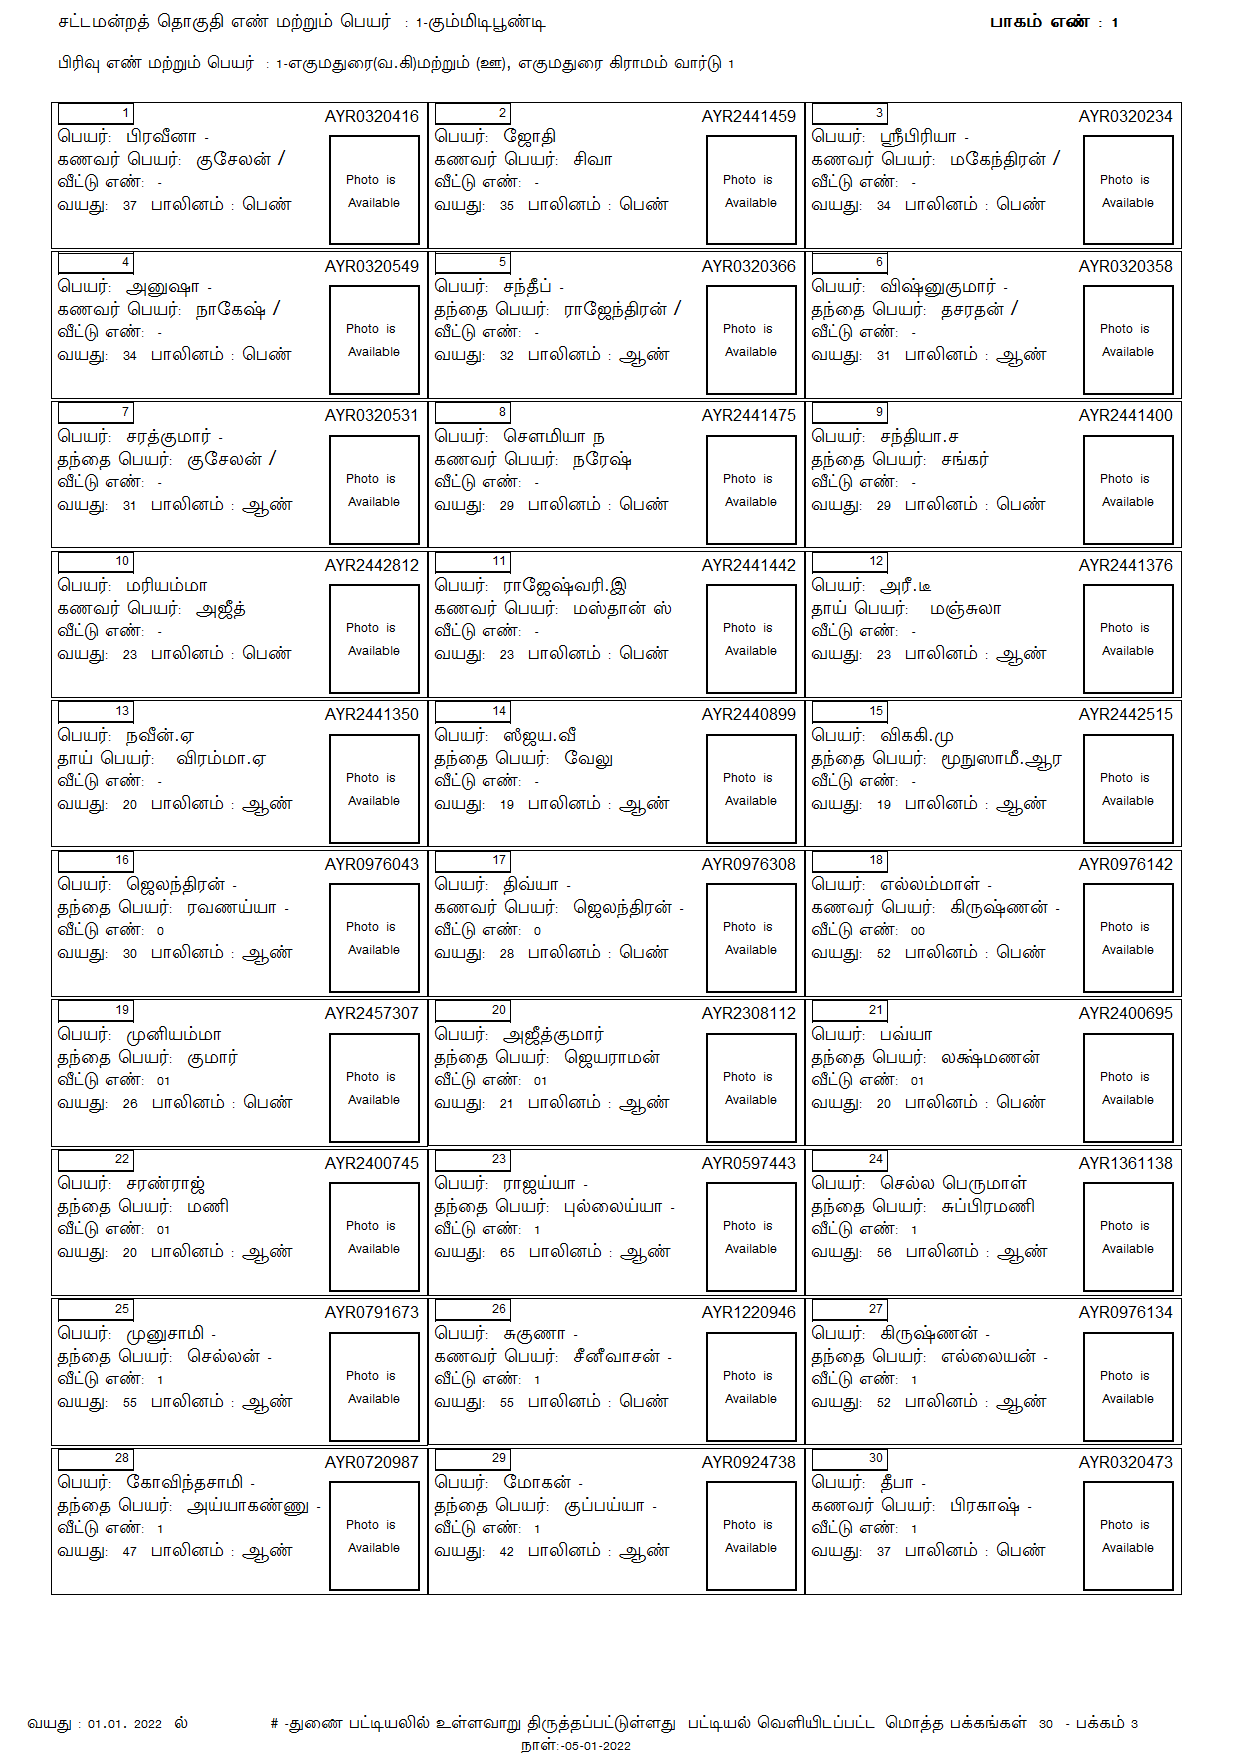

In [5]:
im

In [6]:
pts.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

## $\text{Extract Info}$
---

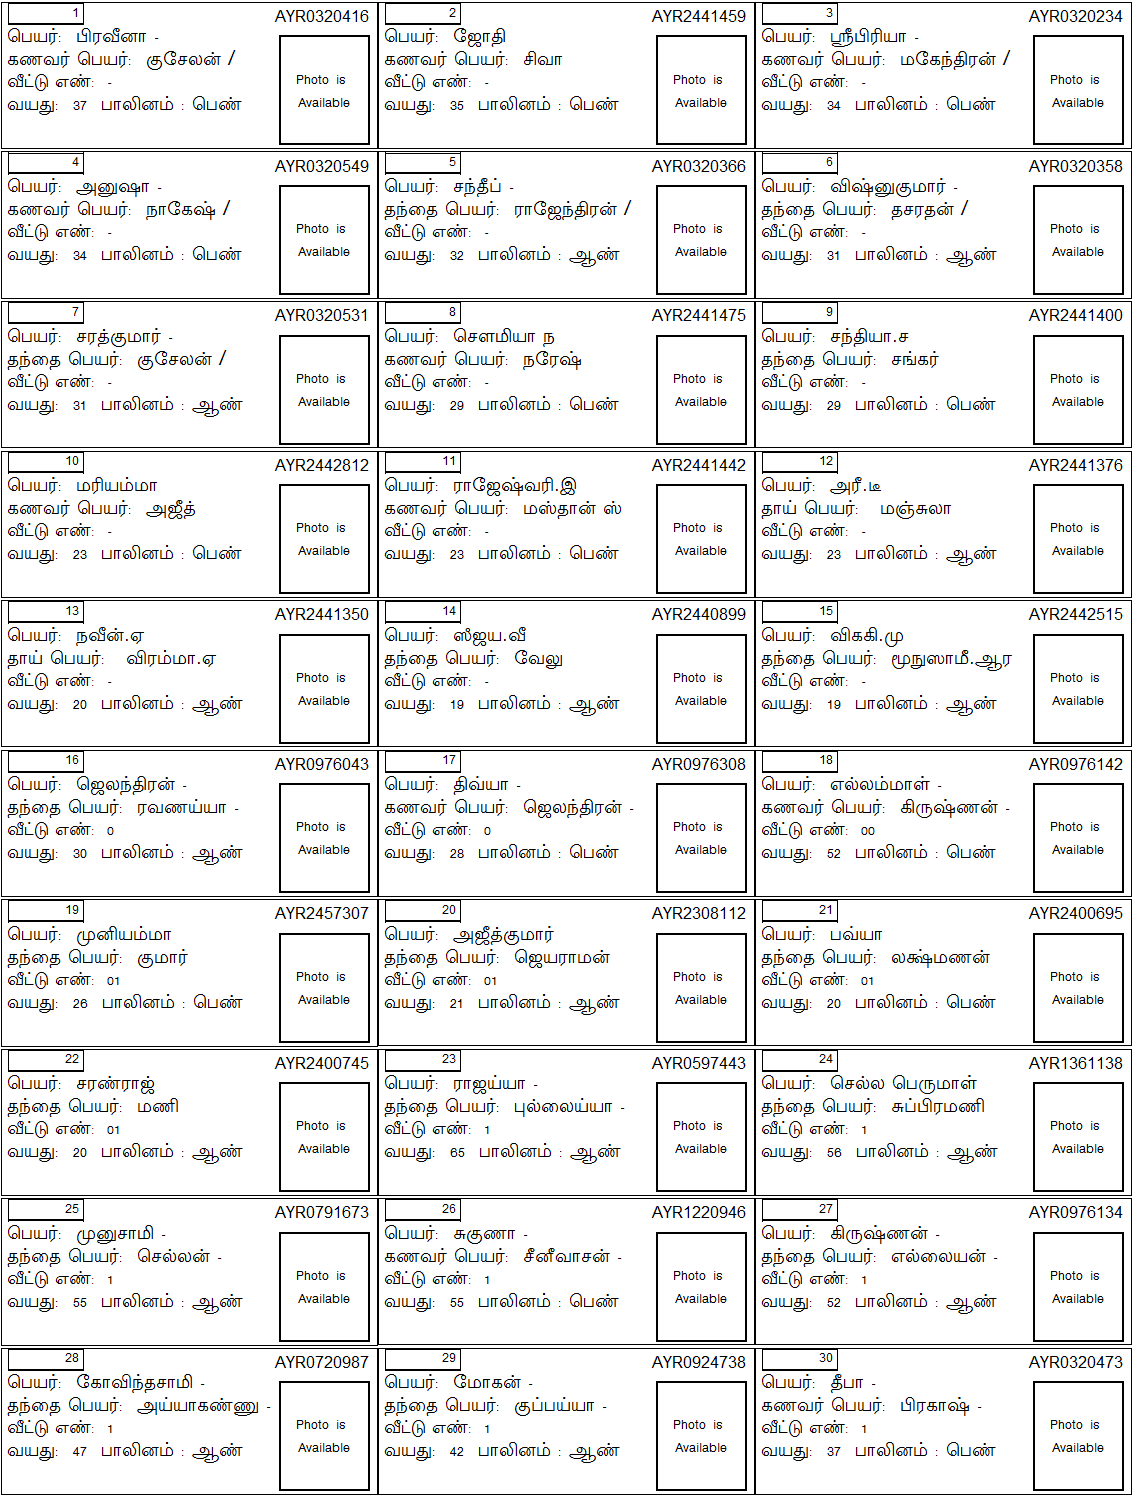

In [7]:
img3 = Image.open('page_3.png')
bounding_box = (50, 100, 1185, 1595)
img_3 = img3.crop(bounding_box)
img_3

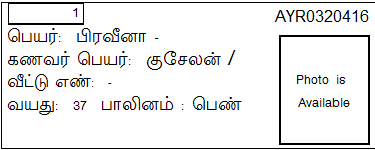

In [8]:
voter = (0, 0, 375, 150)
voter1 = img_3.crop(voter)
voter1

In [9]:
box_id = (250,0,370,25)
voter1_id = voter1.crop(box_id)

In [10]:
voter1_id

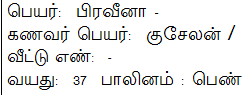

In [11]:
box_info = (0,25,250,120)
voter1_info = voter1.crop(box_info)
voter1_info

In [12]:
box_name = (0,25,180,50)
voter1_name = voter1.crop(box_name)
voter1_name

In [13]:
box_guardian = (0,45,250,73)
voter1_guardian = voter1.crop(box_guardian)
voter1_guardian

In [14]:
box_home = (0, 70, 150, 95)
voter1_home = voter1.crop(box_home)
voter1_home

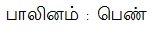

In [15]:
box_gender = (95, 90, 250, 125)
voter1_gender = voter1.crop(box_gender)
voter1_gender

### $\text{For page 3-10}$

#### $\text{Page 3}$

In [16]:
bounding_box = (50, 100, 1185, 1595) # w.r.t. page
voter_box = (0, 0, 375, 150) # w.r.t. bounding_box
# w.r.t voter_box
id_box = (250,0,375,25)  
info_box = (0,25,250,120)
age_box = (0,95,100,125)
home_box = (0, 70, 150, 95)
name_box = (0,25,250,50)
guardian_box = (0,45,250,73)
gender_box = (95, 90, 250, 125)

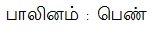

In [17]:
vts = img3.crop(bounding_box)
vt = vts.crop(voter_box).crop(gender_box)
vt

In [18]:
imgs = []
for row in range(10):
    for col in range(3):
        box = (375*col, 150*row, 375*(col+1), 150*(row+1))
        imgs.append(img_3.crop(box))

In [19]:
len(imgs)

30

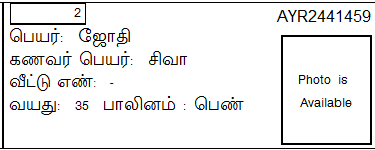

In [20]:
imgs[1]

In [21]:
translator = Translator()

In [22]:
def extract_voter_id(image):
    id_box = (250,0,375,25)
    id_img = image.crop(id_box)
    voter_id = pts.image_to_string(id_img)[:-1]
    return voter_id

In [23]:
extract_voter_id(imgs[14])

'AYR2442515'

In [24]:
def extract_voter_name(image):
    name_box = (0,25,250,50)
    name_img = image.crop(name_box)
    text = pts.image_to_string(name_img, lang = 'tam')
    # text = re.sub('\u200c', '', text)
    # parts = text.split(':')
    tx = translator.translate(text, src = 'ta', dest = 'en')
    voter_name = re.sub('Name:','',tx.text).strip()
    return voter_name

In [25]:
extract_voter_name(imgs[21])

'Saranraj'

In [26]:
def extract_voter_guardian(image):
    guardian_box = (0,45,250,73)
    guardian_img = image.crop(guardian_box)
    text = pts.image_to_string(guardian_img, lang = 'tam')
    tx = translator.translate(text, src = 'ta', dest = 'en')
    voter_guardian = tx.text.split(':')[1].strip()
    return voter_guardian

In [27]:
extract_voter_guardian(imgs[1])

'Siva'

In [28]:
def extract_voter_home(image):
    home_box = (0, 70, 150, 95)
    home_img = image.crop(home_box)
    text = pts.image_to_string(home_img, lang = 'tam')
    tx = translator.translate(text, src = 'ta', dest = 'en')
    # voter_home = re.findall(r'\b\d{2,}\b', tx.text)
    voter_home = re.findall(r'\d+', tx.text)
    return voter_home[0] if voter_home else '-'
    # return voter_age

In [29]:
extract_voter_home(imgs[27])

'1'

In [30]:
def extract_voter_age(image):
    age_box = (0,95,100,125)
    age_img = image.crop(age_box)
    # voter_age = pts.image_to_string(age_img)
    voter_age = int(re.findall(r'\d+', pts.image_to_string(age_img))[0])
    return str(voter_age)

In [31]:
extract_voter_age(imgs[27])

'47'

In [32]:
def extract_voter_gender(image):
    gender_box = (95, 90, 250, 125)
    gender_img = image.crop(gender_box)
    text = pts.image_to_string(gender_img, lang = 'tam')
    tx = translator.translate(text, src = 'ta', dest = 'en')
    voter_gender = re.sub('Gender:', '', tx.text).strip()
    return voter_gender

In [33]:
extract_voter_gender(imgs[25])

'Female'

In [34]:
def image_to_info(image):
    data = {}
    data['Voter ID'] = extract_voter_id(image)
    data['Name'] = extract_voter_name(image)
    data['Guardian Name'] = extract_voter_guardian(image)
    data['Home Number'] = extract_voter_home(image)
    data['Age'] = extract_voter_age(image)
    data['Gender'] = extract_voter_gender(image)
    
    return data

In [36]:
image_to_info(imgs[1])

{'Voter ID': 'AYR2441459',
 'Name': 'Jyoti',
 'Guardian Name': 'Siva',
 'Home Number': '-',
 'Age': '35',
 'Gender': 'Female'}

In [37]:
image_to_info(imgs[14])

{'Voter ID': 'AYR2442515',
 'Name': '',
 'Guardian Name': 'Munusami.A.',
 'Home Number': '-',
 'Age': '19',
 'Gender': 'Male'}

In [38]:
df3 = pd.DataFrame()

In [39]:
for img in imgs:
    try:
        record = image_to_info(img)
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        continue
    df3 = df3.append(record, ignore_index=True)

In [40]:
df3

,Voter ID,Name,Guardian Name,Home Number,Age,Gender
0,AYRO320416.,Praveena -,Kushelan 7,-,37,Female
1,AYR2441459,Jyoti,Siva,-,35,Female
2,AYR0320234,[ Sripriya -,Mahendran,-,34,Female
3,AYR0320549°,Anusha -,Nagesh 7/,-,34,Female
4,AYR0320366,Sandeep -,Rajendran.,-,32,Male
5,AYR0320358,Vishnukumar -,Dasaratha /,-,31,Male
6,AYRO320531,Sarathkumar -,Kushelan /,-,31,Male
7,AYR2441475.,Soumya,Naresh,-,29,Female
8,AYR2441400,Sandhya.S.,Shankar,-,29,Female
9,AYR2442812,Mariamma,Ajith,-,23,Female


In [42]:
df3.to_csv('page3_clean.csv', index = False, header = True)

#### $\text{Page 4-10}$

In [43]:
bounding_box_alt = (50, 83, 1185, 1580)
voter_box = (0, 0, 375, 150) # w.r.t. bounding_box
# w.r.t voter_box
id_box = (250,0,375,25)  
info_box = (0,25,250,120)
age_box = (0,95,100,125)
home_box = (0, 70, 150, 95)
name_box = (0,25,250,50)
guardian_box = (0,45,250,73)
gender_box = (95, 90, 250, 125)

In [44]:
pngs = []
for p in range(4,11):
    pngs.append(Image.open(f'page_{p}.png'))

In [45]:
imgs_4_10 = []
for img in pngs:
    imgs_4_10.append(img.crop(bounding_box_alt))

In [46]:
voters = []
for ig in imgs_4_10:
    for row in range(10):
        for col in range(3):
            box = (375*col, 150*row, 375*(col+1), 150*(row+1))
            voters.append(ig.crop(box))

In [47]:
len(voters)

210

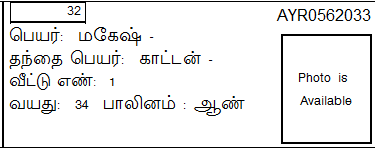

In [49]:
voters[1]

In [48]:
df_4_10 = pd.DataFrame()

In [50]:
time_start = time.time()
fail = 0
for img in voters:
    try:
        record = image_to_info(img)
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        fail+=1
        continue
    df_4_10 = df_4_10.append(record, ignore_index=True)
time_end = time.time()
time_take = time_end - time_start

Error processing image: list index out of range
Error processing image: the JSON object must be str, bytes or bytearray, not NoneType
Error processing image: the JSON object must be str, bytes or bytearray, not NoneType
Error processing image: the JSON object must be str, bytes or bytearray, not NoneType
Error processing image: the JSON object must be str, bytes or bytearray, not NoneType
Error processing image: list index out of range
Error processing image: list index out of range
Error processing image: list index out of range
Error processing image: list index out of range
Error processing image: list index out of range
Error processing image: list index out of range
Error processing image: the JSON object must be str, bytes or bytearray, not NoneType
Error processing image: the JSON object must be str, bytes or bytearray, not NoneType
Error processing image: list index out of range
Error processing image: the JSON object must be str, bytes or bytearray, not NoneType
Error processi

In [51]:
(fail/len(voters)) * 100

12.380952380952381

In [53]:
time_take/60

11.139494887987773

In [54]:
df_4_10.to_csv('page4_10_clean.csv', index = False, header = True)